Project plan

1. problem formulation :  
Context : we have been instructed to predict books ratings from provided data   
2. Data preprocessing
3. EDA
4. features engineering 
5. modelling & Machine learning 
6. Model validation
7. deployment

In [1]:
!conda env list 

# conda environments:
#
                         /Users/mpaga/Library/r-miniconda
                         /Users/mpaga/Library/r-miniconda/envs/r-reticulate
                         /Users/mpaga/miniconda3
base                  *  /Users/mpaga/opt/anaconda3
Project1                 /Users/mpaga/opt/anaconda3/envs/Project1
bootcamp                 /Users/mpaga/opt/anaconda3/envs/bootcamp
pandas_cookBook          /Users/mpaga/opt/anaconda3/envs/pandas_cookBook
pandas_cookbook          /Users/mpaga/opt/anaconda3/envs/pandas_cookbook
tf                       /Users/mpaga/opt/anaconda3/envs/tf
                         /Users/mpaga/tf
                         /usr/local/bin



In [2]:
# install libraries 
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install plotly 
#!pip install -U scikit-learn
#!pip install datetime 

In [3]:
# load libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import plotly as ply
import sklearn as skl
import datetime as dt

In [4]:
# load data 
df = pd.read_csv("books.csv")

2 Data preprocessing 

2.1  inspect data 

In [5]:
df.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.


In [6]:
df.tail(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco
11126,45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,5/28/2006,Edimat Libros


In [7]:
# df shape 
df.shape

(11127, 12)

In [8]:
# df info
#df.info()

In [9]:
# columns names
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [10]:
# describe numeric variables
df.describe(exclude="object").T

,count,mean,std,min,25%,50%,75%,max
bookID,11127.0,2.131094e+04,1.309336e+04,1.000000e+00,1.028700e+04,2.028700e+04,3.210450e+04,4.564100e+04
average_rating,11127.0,3.933631e+00,3.524450e-01,0.000000e+00,3.770000e+00,3.960000e+00,4.135000e+00,5.000000e+00
isbn13,11127.0,9.759888e+12,4.428964e+11,8.987060e+09,9.780345e+12,9.780586e+12,9.780873e+12,9.790008e+12
num_pages,11127.0,3.363769e+02,2.411273e+02,0.000000e+00,1.920000e+02,2.990000e+02,4.160000e+02,6.576000e+03
ratings_count,11127.0,1.793641e+04,1.124794e+05,0.000000e+00,1.040000e+02,7.450000e+02,4.993500e+03,4.597666e+06
text_reviews_count,11127.0,5.418545e+02,2.576177e+03,0.000000e+00,9.000000e+00,4.600000e+01,2.375000e+02,9.426500e+04


In [11]:
# describe non-numeric  variables
df.describe(include="object").T

,count,unique,top,freq
title,11127,10352,The Brothers Karamazov,9
authors,11127,6643,Stephen King,40
isbn,11127,11127,0439785960,1
language_code,11127,27,eng,8911
publication_date,11127,3679,10/1/2005,56
publisher,11127,2292,Vintage,318


In [12]:
# unique BookID ?
len(df.bookID)== df.shape[0]

True

There is no duplicate ID in data 

2.2  clean data 

In [13]:
# change from string to datetime object 
# for loop to parse date 
df["publication_Date"]= pd.Series(dtype="int")
cnt = 0
for i in range(len(df.publication_date)) :
    month,day,year = map(int,df.publication_date[i].split('/'))

    if month in [4,6,9,11] and day > 30:
        day = 30
        df["publication_Date"][i] = dt.date(year,month,day)
    elif(month==2 and day > 28 and year % 4 != 0):
        day = 28
    df["publication_Date"][i] = dt.date(year,month,day)
    cnt +=1
if (cnt == len(df.publication_date)) :
    print("no date issue" )
 

/var/folders/dr/qtbb25gd2pl7ssnx51bqxv6r0000gp/T/ipykernel_2625/1680810485.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["publication_Date"][i] = dt.date(year,month,day)


no date issue


In [14]:
# remove publication date 
df=df.drop("publication_date",axis=1)
df.publication_Date.describe()

count          11127
unique          3678
top       2005-10-01
freq              56
Name: publication_Date, dtype: object

In [15]:
# remove heading whitespace from num_pages features 
df = df.rename(columns = {"  num_pages" : "num_pages"})
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'publication_Date'],
      dtype='object')

In [16]:
#na check 
df.isna().sum().sum()

0

There is no NA in df

In [17]:
# na check in average_rating
if (df.average_rating.isna().mean() == 0 ) :
    print("There is no NA in average_rating")
else:
    print("There are NA in average_rating")

There is no NA in average_rating


3 EDA 

In [18]:
# describe df
df.describe(include="number")

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,21310.938887,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,13093.358023,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10287.000000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780586e+12,299.000000,7.450000e+02,46.000000
75%,32104.500000,4.135000,9.780873e+12,416.000000,4.993500e+03,237.500000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


3.1 Numerical summary and 1D plot

In [19]:
# numerical summary average_rating 
df.average_rating.describe()

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

<AxesSubplot: >

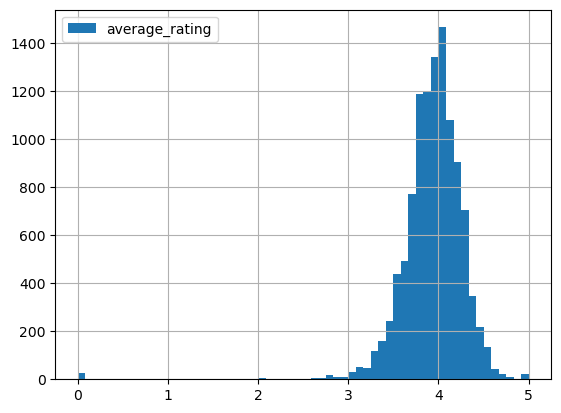

In [20]:
# histogram of average ratings 
df.average_rating.hist(bins=60,legend={""})

<AxesSubplot: >

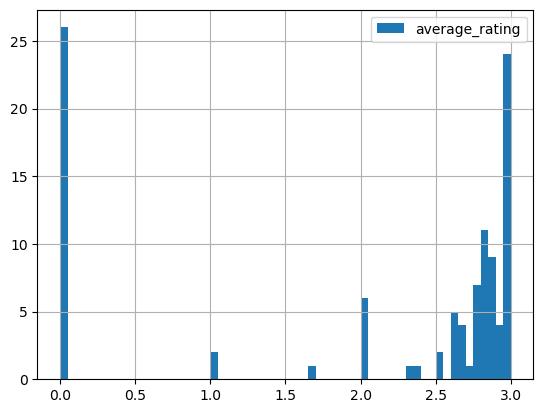

In [21]:
# histogram of average ratings :range [0,3.9]
df.average_rating.hist(bins=60,range = [0,3],legend={""})

<AxesSubplot: >

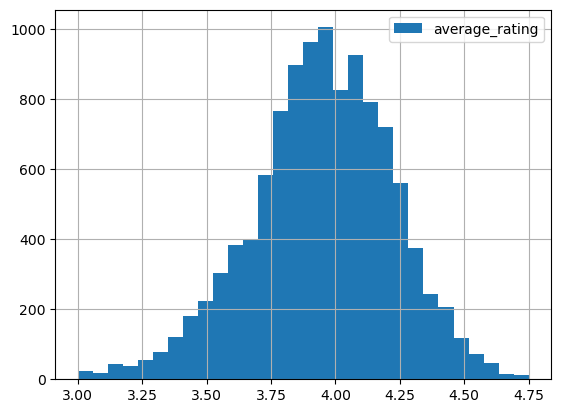

In [22]:
# histogram of average ratings :range [0,4.75]
df.average_rating.hist(bins=30,range = [3,4.75],legend={""})

<AxesSubplot: >

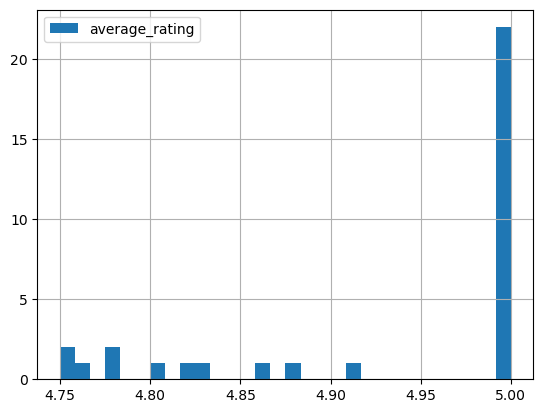

In [23]:
# histogram of average ratings :range [0,3.9]
df.average_rating.hist(bins=30,range = [4.75,5],legend={""})

In [24]:
df.loc[df.average_rating <= 3].shape

(104, 12)

In [25]:
df.loc[df.average_rating > 4.75].shape

(31, 12)

average_ratings is almost an unimodal distribution with an outlier.

In [26]:
#numerical summary num_pages
df.num_pages.describe()

count    11127.000000
mean       336.376921
std        241.127305
min          0.000000
25%        192.000000
50%        299.000000
75%        416.000000
max       6576.000000
Name: num_pages, dtype: float64

<AxesSubplot: >

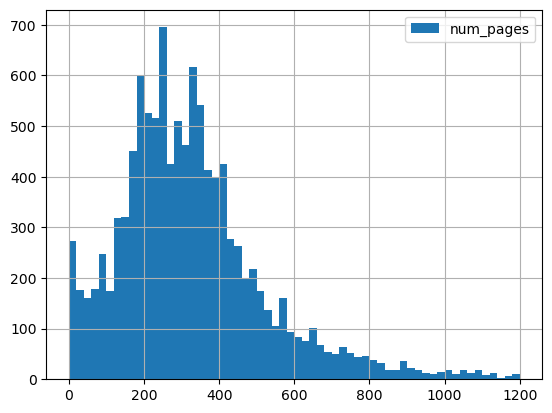

In [27]:
# histogram of num_pages 
df.num_pages.hist(bins = 60,range=[0,1200],legend={""})

<AxesSubplot: >

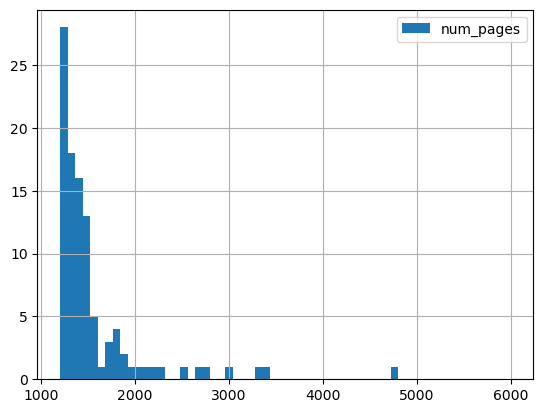

In [28]:
# histogram of num_pages 
df.num_pages.hist(bins = 60,range=[1200,6000],legend={""})

Num_pages is bimodal distribution, right skewed showing that  at least 50% of books present 299 pages.

In [29]:
df[df.num_pages <= 1200].shape

(11026, 12)

In [30]:
df[df.num_pages >1200].shape

(101, 12)

In [31]:
# numerical summary authors 
df.authors.describe()

count            11127
unique            6643
top       Stephen King
freq                40
Name: authors, dtype: object

In [32]:
# sort authors
#(df
 #.groupby("authors")
 #.aggregate("mean")
 #.sort_values(by=["average_rating","text_reviews_count"],ascending=False)
 #[["average_rating","text_reviews_count"]]
 #.head(5)
#)

In [33]:
# numerical summary text_reviews_count 
df.text_reviews_count.describe()

count    11127.000000
mean       541.854498
std       2576.176608
min          0.000000
25%          9.000000
50%         46.000000
75%        237.500000
max      94265.000000
Name: text_reviews_count, dtype: float64

<AxesSubplot: >

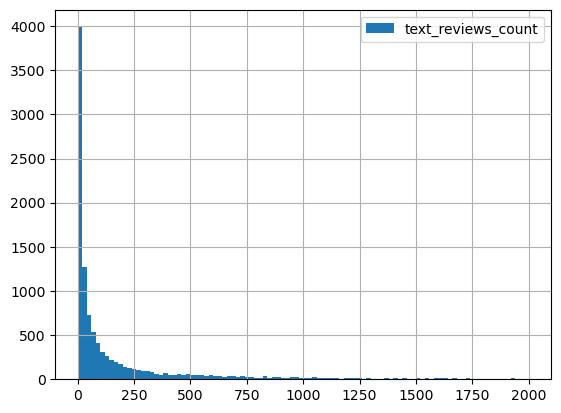

In [34]:
#histogram of text_reviews_count
df.text_reviews_count.hist(bins = 100,range =[0,2000],legend={""})


text reviews count present an unimodal and is right skewed distribution. At least 50% of books text reviews count are greater or equal to 46.

In [35]:
# numerical summary ratings_count 
df.ratings_count.describe()

count    1.112700e+04
mean     1.793641e+04
std      1.124794e+05
min      0.000000e+00
25%      1.040000e+02
50%      7.450000e+02
75%      4.993500e+03
max      4.597666e+06
Name: ratings_count, dtype: float64

<AxesSubplot: >

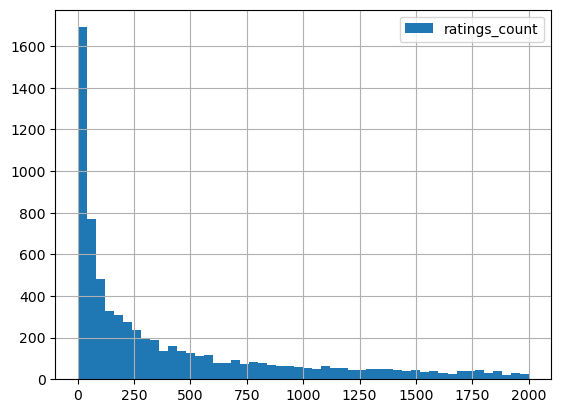

In [36]:
# histogram of ratings_count 
df.ratings_count.hist(bins = 50,range = [0,2000],legend ={""})

Ratings count distribution is unimodal, right sekewed. At least 50% of books ratings count is greater or equal to 745.

In [37]:
# numerical summary publication Date
df.publication_Date.describe()

count          11127
unique          3678
top       2005-10-01
freq              56
Name: publication_Date, dtype: object

In [38]:
(df
["publication_Date"]
.quantile([0.0,0.25,0.5,0.75,1])
)

0.00    1900-01-01
0.25    1998-07-17
0.50    2003-03-01
0.75    2005-09-30
1.00    2020-03-31
Name: publication_Date, dtype: object

<AxesSubplot: >

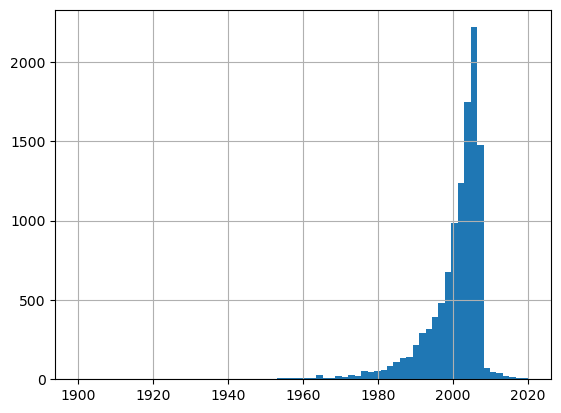

In [39]:
# histogram of publication date 
df.publication_Date.hist(bins = 70)

publication date distribution is unimodal and left skewed. At least 50% of books has been published before 2003.

3.2 Numerical summary and  2D plot 

REPRISE!

<AxesSubplot: xlabel='num_pages', ylabel='average_rating'>

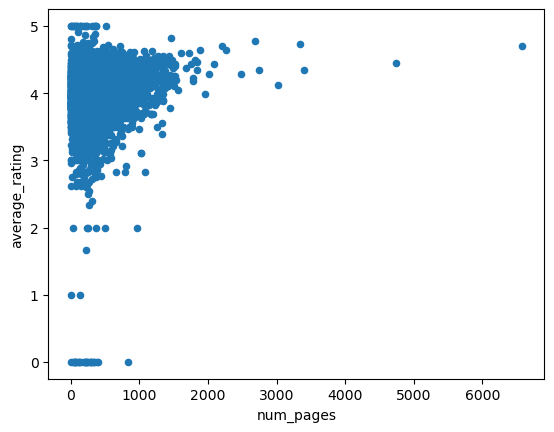

In [40]:
# scatter plot average rating vs num_pages
df.plot.scatter(x="num_pages",y = "average_rating")

<AxesSubplot: xlabel='text_reviews_count', ylabel='average_rating'>

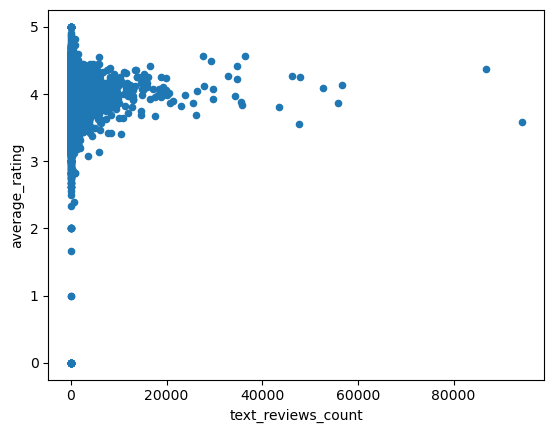

In [41]:
# scatter plot average_rating vs text_reviews_count 
df.plot.scatter(x="text_reviews_count",y = "average_rating")

<AxesSubplot: xlabel='ratings_count', ylabel='average_rating'>

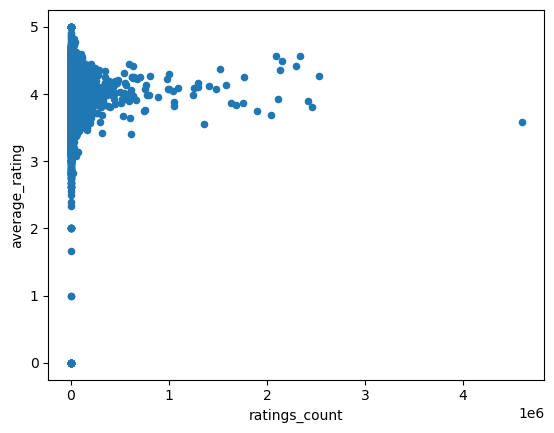

In [42]:
# scatter plot average rating. vs ratings count 
df.plot.scatter(x="ratings_count",y = "average_rating")

3.3  Numerical variables correlations 

In [43]:
# correlation table
(df.select_dtypes(include = "number")
.drop(["bookID","isbn13"],axis = 1)
.corr()
)


,average_rating,num_pages,ratings_count,text_reviews_count
average_rating,1.000000,0.150809,0.038205,0.033734
num_pages,0.150809,1.000000,0.034353,0.036998
ratings_count,0.038205,0.034353,1.000000,0.865979
text_reviews_count,0.033734,0.036998,0.865979,1.000000


-numerical features are not correlated 

4 features engineering part1  
we are going to remove variables without any variations :
bookID, title , authors,isbn,isbn13, language_code, publisher

In [44]:
# create a new dataframe : df1
df1 = df[['bookID','title','authors','isbn','isbn13',
               'publisher']]
df1.shape

(11127, 6)

In [45]:
df.average_rating.isna().sum()

0

4.1 Discretize average_rating

In [46]:
df1["av_cat"] = pd.cut(df.average_rating,bins=[0,3,4,5],
                    labels = ["low","medium","high"], include_lowest=True)

/var/folders/dr/qtbb25gd2pl7ssnx51bqxv6r0000gp/T/ipykernel_2625/267632947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["av_cat"] = pd.cut(df.average_rating,bins=[0,3,4,5],


In [47]:
df1.av_cat.head(3)

0    high
1    high
2    high
Name: av_cat, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [48]:
df1.av_cat.tail(3)

11124    medium
11125    medium
11126    medium
Name: av_cat, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [49]:
round(df1.av_cat.value_counts()/ len(df1.av_cat),3)

medium    0.565
high      0.426
low       0.009
Name: av_cat, dtype: float64

<AxesSubplot: >

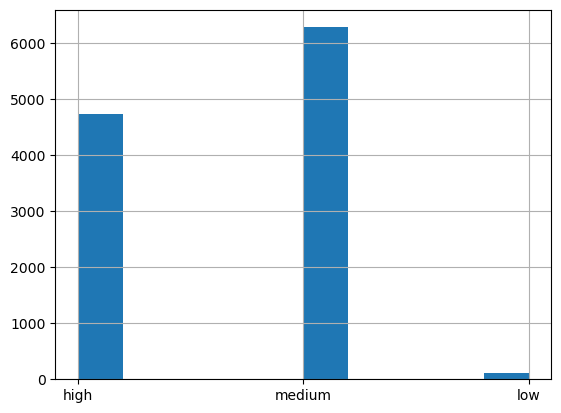

In [50]:
df1.av_cat.hist()

Discretizing average_rating  make it unbalanced data.   May be we need to consider it a regression problem instead.

4.2 Splitting data 

In [51]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'publication_Date'],
      dtype='object')

In [52]:
# selecting numerical features
df1 = df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']]

In [53]:
df1.average_rating.isna().sum()

0

In [54]:
df1.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count
0,4.57,652,2095690,27591
1,4.49,870,2153167,29221
2,4.42,352,6333,244


In [55]:
#df1["eng"]= 1*(df1.language_code == "eng")

In [56]:
#df1 = df1.drop('language_code',axis = 1)

In [57]:
from sklearn.model_selection import train_test_split
train0,test = train_test_split(df1, test_size= 20,random_state=42)

In [58]:
# split train0 in train and valid 
train,valid = train_test_split(train0,test_size=40,random_state=42)

In [59]:
# subsetting 
# train0
X_train0 = train0.drop("average_rating",axis = 1)
y_train0 = train0.average_rating

# train
X_train = train.drop("average_rating",axis = 1)
y_train = train.average_rating

# valid 
X_valid = valid.drop("average_rating",axis=1)
y_valid = valid.average_rating

# test 
X_test = test.drop("average_rating",axis = 1)
y_test = test.average_rating

5 modelling 

5.1 Linear models

-linear model : OLS

In [60]:
# linear model 
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)


LinearRegression()

In [61]:

# regression coefficients 
reg.coef_

array([ 2.19042388e-04,  1.07767098e-07, -2.07788059e-07])

-regularized linear models

-Ridge : alpha = 0.01 

In [62]:
# regularized model : ridge model, alpha = 0.1 
reg_ridge = linear_model.Ridge(alpha=0.01)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.01)

-ridge alphas, cv = 5

In [63]:
# ridge model with cross validation 
# regularized model : ridge model with cv =5
reg_ridge_CV = linear_model.RidgeCV(alphas=[0.001,0.01,0.1,1,10],cv=5)
reg_ridge_CV.fit(X_train0,y_train0)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)

-Lasso

In [64]:
#from sklearn import linear_model, alpha = 0.5
reg_lasso = linear_model.Lasso(alpha=0.5)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.5)

5.2 Tree based model 

In [65]:
# tree based model 
from sklearn import tree
regressor = tree.DecisionTreeRegressor(random_state=40)
tree_reg= regressor.fit(X_train,y_train)

5.3 Ensemble models

In [66]:
 #random forest
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators= 100,
#max_depth = 5,
random_state=42)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

5.4 Support vectors machine 

In [67]:
# linear svm
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, random_state=0)
svm_regr = make_pipeline(StandardScaler(),
                     LinearSVR(random_state=0, tol=1e-5,max_iter=10000))
svm_regr.fit(X, y)

#

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(max_iter=10000, random_state=0, tol=1e-05))])

In [68]:
# scale X_train and Y_train
#X_train_scaled = StandardScaler().fit(X_train)
#y_train_scaled = StandardScaler().fit(y_train)

In [69]:
# SVR
#linear_svm = svm.SVR(kernel='linear')
#rbf_svm = svm.SVR(kernel='rbf')

# fit
#linear_svm.fit(X_train_scaled,y_train_scaled)


In [70]:
# radial based svm
#rbf_svm.fit(X_train,y_train)

5.5 Multilayers perceptron

In [71]:
# MLP

In [72]:
#skl.metrics.get_scorer_names() : to find models metrics 

In [73]:
# cross val custom function 
def model_cross_val(models={}, X_test=None,y_test= None,cv=None, scoring = "neg_mean_squared_error"):
    from sklearn.model_selection import cross_val_score
    table = []
    for mod in models :
        score = abs(
            cross_val_score(models[mod],X_test,y_test,cv=cv,scoring=scoring ).mean())
        table.append(abs(score))
    print(
         pd.DataFrame(data = table,index = models,columns = ["rmse"])
        .sort_values(by ="rmse")
        
    )



6 cross-validated models 

In [74]:
# models cross val evaluation
models = {"linear reg": reg,"ridge model":reg_ridge,"lasso model ": reg_lasso,
"ridge CV":reg_ridge_CV,"random forest":rf,"linear svm":svm_regr}

# cross_val eval 
model_cross_val(models,X_test,y_test,cv= 5)

                   rmse
linear svm     0.040977
random forest  0.048667
lasso model    0.049916
ridge CV       0.112208
ridge model    0.112210
linear reg     0.112210


In [75]:
df1.average_rating.isna().sum()

0

-Outliers effect on models:
lets fit model without outliers.

-modelling without outliers 

In [76]:
# remove outliers from a erage rating only
df2 = df.loc[df.average_rating >= 2,['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']]

In [77]:
df2.shape

(11098, 4)

In [78]:
# detect and remove outliers function
def remove_outliers(X,bins = 50, plot = "bool"):
    # q1 and q3 quantiles
    q1,q3 = X.quantile([0.25,0.75])
    #print(q1,q3)

    #interquatile range 
    iqr = q3 - q1
    #print(pd.DataFrame([[q1, q3 ,iqr]],columns = ["q1","q3","IQR"]))

    # remove 
    if q1 - 1.5*iqr < 0 :
      X =  X[X.between(q1 - 1.5*iqr, q3 + 1.5*iqr,inclusive = "both")]
       
    else:
      X = X[X.between(q1 - 1.5*iqr, q3 + 1.5*iqr,inclusive = "both")]
    # histogram
    if plot :
      X.hist( bins = bins,legend = {""})
    return X



<AxesSubplot: >

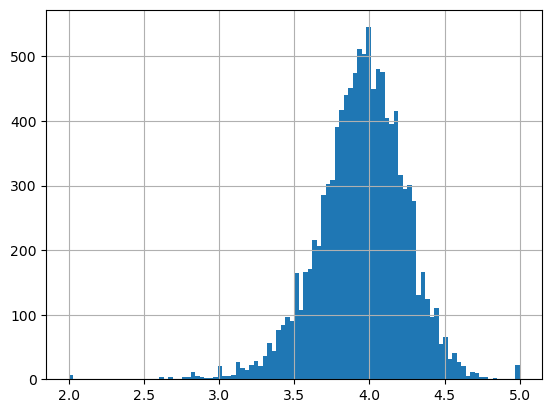

In [79]:
df2.average_rating.hist(bins = 100)


0        4.57
1        4.49
2        4.42
3        4.56
5        3.74
         ... 
11122    4.06
11123    4.08
11124    3.96
11125    3.72
11126    3.91
Name: average_rating, Length: 10877, dtype: float64

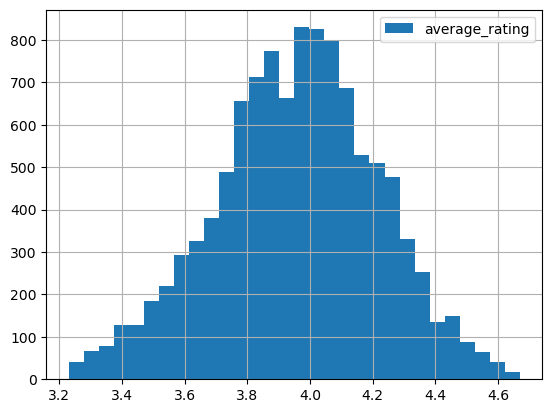

In [80]:

remove_outliers(df.average_rating, bins = 30)


2        244
4        164
5          1
7        254
9        460
        ... 
11122     20
11123     56
11124     95
11125    139
11126     12
Name: text_reviews_count, Length: 9496, dtype: int64

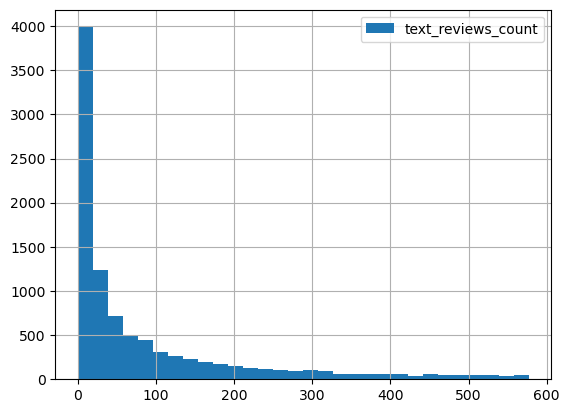

In [81]:
remove_outliers(df1.text_reviews_count,bins = 30)

2        6333
5          19
7        3628
9        4930
10       1266
         ... 
11122     156
11123     783
11124     820
11125     769
11126     113
Name: ratings_count, Length: 9398, dtype: int64

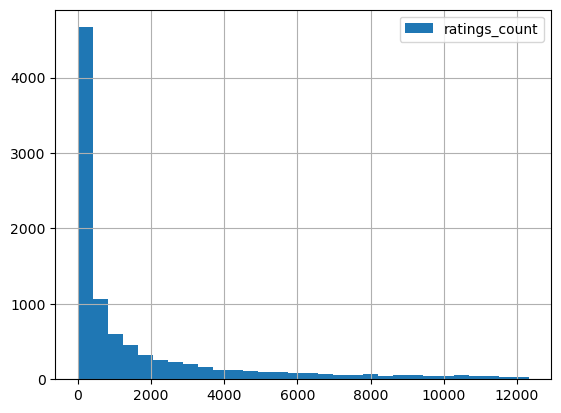

In [82]:
remove_outliers(df1.ratings_count,bins = 30)

0        652
2        352
3        435
5        152
9        215
        ... 
11122    512
11123    635
11124    415
11125    434
11126    272
Name: num_pages, Length: 10587, dtype: int64

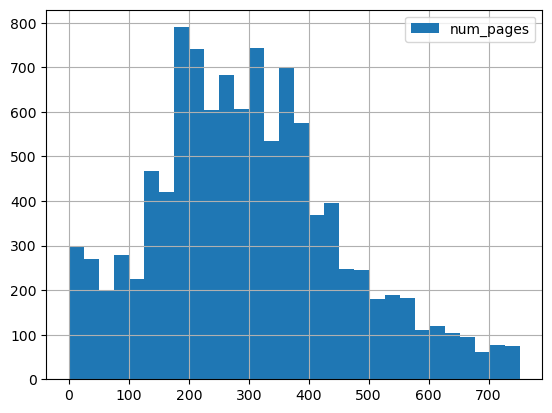

In [83]:
remove_outliers(df1.num_pages,bins = 30)

In [84]:
df2.isna().sum()

average_rating        0
num_pages             0
ratings_count         0
text_reviews_count    0
dtype: int64

In [85]:
# split data
train,test = train_test_split(df2, test_size= 0.4,random_state=42)

# train
X_train = train.drop("average_rating",axis=1)
y_train = train.average_rating

# test
X_test = test.drop("average_rating",axis=1)
y_test = test.average_rating

In [86]:
# linear model 
reg.fit(X_train,y_train)

LinearRegression()

In [87]:
# lasso
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.5)

In [88]:
#ridge
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.01)

In [89]:
# random forest
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [90]:
# svm
svm_regr.fit(X_train, y_train)

/Users/mpaga/opt/anaconda3/envs/Project1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(max_iter=10000, random_state=0, tol=1e-05))])

7 Models new evaluation

In [91]:
model_cross_val(models=models,X_test=X_test, y_test=y_test, cv = 10)

/Users/mpaga/opt/anaconda3/envs/Project1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mpaga/opt/anaconda3/envs/Project1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mpaga/opt/anaconda3/envs/Project1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mpaga/opt/anaconda3/envs/Project1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                   rmse
lasso model    0.085798
ridge CV       0.085799
ridge model    0.085799
linear reg     0.085799
linear svm     0.085949
random forest  0.090706


There is a slight outliers effect. Lasso model is the winning candidate.